#### Content

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in **two days**, where we have **492 frauds** out of **284,807 transactions**. The dataset is highly unbalanced, the positive class (frauds) account for **0.172%** of all transactions.

#### Overview of the Dataset

#### Source : The dataset used in this notebook is the well-known Credit Card Fraud Detection dataset from Kaggle.

#### Description :

##### The dataset contains anonymized credit card transactions made by European cardholders over two days.
##### It includes features derived from **PCA** (Principal Component Analysis), such as V1, V2, ..., V28, along with **Time** (time elapsed between transactions) and **Amount** (transaction amount).
##### The target variable is Class, where:
0 = legitimate transaction
1 = fraudulent transaction

#### Key Characteristics :
Highly imbalanced dataset: Only **0.172%** of transactions are fraudulent.
Anonymized features make it challenging to interpret the data directly.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

In [2]:
data = pd.read_csv("creditcard.csv")


#### Data Exploration

##### Summary Statistics :
Basic descriptive statistics (mean, median, min, max) for numerical features.

Distribution of the Class variable shows the extreme imbalance between fraud and non-fraud cases.

In [3]:
data.head() 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.describe() # Summary Statistics for Numerical Features

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
# Distribution of the 'Class' variable
print("\nDistribution of the 'Class' variable:")
class_distribution = data['Class'].value_counts()
print(class_distribution)




Distribution of the 'Class' variable:
Class
0    284315
1       492
Name: count, dtype: int64


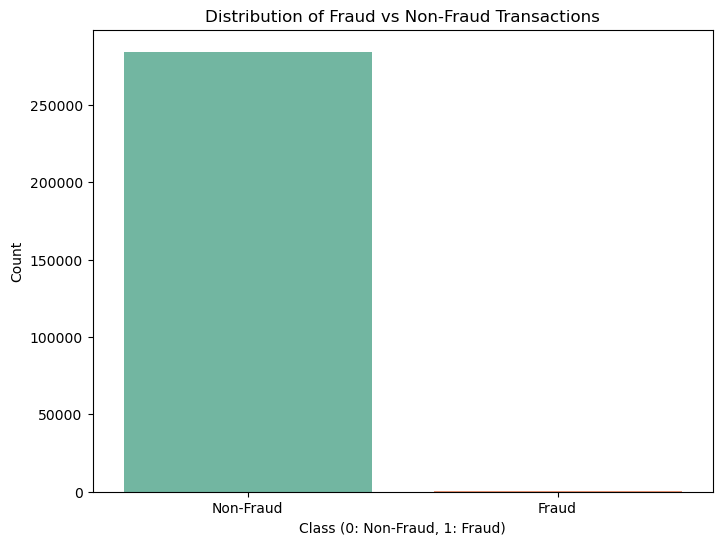

In [6]:
# Visualize the distribution of the 'Class' variable
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Class', palette='Set2')
plt.title('Distribution of Fraud vs Non-Fraud Transactions')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Fraud', 'Fraud'])
plt.show()



In [7]:
# Calculate the percentage of fraud and non-fraud cases
fraud_percentage = (class_distribution[1] / class_distribution.sum()) * 100
non_fraud_percentage = (class_distribution[0] / class_distribution.sum()) * 100

print(f"\nPercentage of Fraud Cases: {fraud_percentage:.2f}%")
print(f"Percentage of Non-Fraud Cases: {non_fraud_percentage:.2f}%")


Percentage of Fraud Cases: 0.17%
Percentage of Non-Fraud Cases: 99.83%


#### Feature Engineering

1)Feature Scaling : Applying StandardScaler to normalize the Amount feature.

2)Time-Based Features : Transforming the Time feature into meaningful features like time of day (e.g., morning, afternoon, evening, night) and day vs. night.

In [8]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler

In [9]:
#Feature Scaling - Normalize the 'Amount' feature using StandardScaler
scaler = StandardScaler()
data['Amount_Scaled'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1)) #A new column Amount_Scaled is created to store the scaled values.

In [10]:
# Total seconds in a day = 86400, so we can calculate the hour of the day
data['Hour'] = (data['Time'] / 3600) % 24  # Convert seconds to hours (0-23)

# Categorize hours into time periods: Morning, Afternoon, Evening, Night
def get_time_period(hour):
    if 5 <= hour < 12:  # Morning: 5 AM to 11:59 AM
        return 'Morning'
    elif 12 <= hour < 17:  # Afternoon: 12 PM to 4:59 PM
        return 'Afternoon'
    elif 17 <= hour < 21:  # Evening: 5 PM to 8:59 PM
        return 'Evening'
    else:  # Night: 9 PM to 4:59 AM
        return 'Night'

data['Time_Period'] = data['Hour'].apply(get_time_period)

#### Label encoding converts categorical values (e.g., 'Morning', 'Afternoon', 'Evening' , 'Night'.) into numeric codes (e.g., 0, 1, 2, 3.)

In [11]:
from sklearn.preprocessing import LabelEncoder

# Apply the get_time_period function to create the 'Time_Period' column
data['Time_Period'] = data['Hour'].apply(get_time_period)

# Use LabelEncoder to encode 'Time_Period' into numeric values
label_encoder = LabelEncoder()
data['Time_Period_Encoded'] = label_encoder.fit_transform(data['Time_Period'])

# Drop the original 'Time_Period' column (optional)
data.drop(columns=['Time_Period'], inplace=True)

# Display the updated dataset
print("\nDataset with Encoded Time Period:")
print(data[['Hour', 'Time_Period_Encoded']].head())


Dataset with Encoded Time Period:
       Hour  Time_Period_Encoded
0  0.000000                    3
1  0.000000                    3
2  0.000278                    3
3  0.000278                    3
4  0.000556                    3


In [12]:
# create a binary feature for Day vs. Night
data['Is_Night'] = data['Hour'].apply(lambda x: 1 if 21 <= x or x < 5 else 0)

In [13]:
# Drop the original 'Time' and 'Amount' columns as they are replaced by new features
data.drop(columns=['Time','Amount'], inplace=True)

In [14]:
# Display the updated dataset with new features
print("\nUpdated Dataset with New Features:")
print(list(data.columns))


Updated Dataset with New Features:
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'Amount_Scaled', 'Hour', 'Time_Period_Encoded', 'Is_Night']


In [15]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V24,V25,V26,V27,V28,Class,Amount_Scaled,Hour,Time_Period_Encoded,Is_Night
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,0.000000,3,1
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,0.000000,3,1
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,0.000278,3,1
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,0.000278,3,1
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,0.000556,3,1


In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter


#### 1. Split the Data into Training and Testing Sets



In [17]:
# Split the data into training and testing sets
X = data.drop(columns=['Class'])  # Features
y = data['Class']                 # Target variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### 2. Handle Class Imbalance Using SMOTE 

In [18]:
# Check the distribution of the target variable before applying SMOTE
print("Before SMOTE - Training set class distribution:")
print(Counter(y_train))

Before SMOTE - Training set class distribution:
Counter({0: 227451, 1: 394})


In [19]:
# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [20]:
# Check the distribution of the target variable after applying SMOTE
print("\nAfter SMOTE - Training set class distribution:")
print(Counter(y_train_resampled))


After SMOTE - Training set class distribution:
Counter({0: 227451, 1: 227451})


In [21]:
# Combine resampled features and target into a single DataFrame for EDA
resampled_df = pd.DataFrame(X_train_resampled, columns=X_train.columns)
resampled_df['Class'] = y_train_resampled

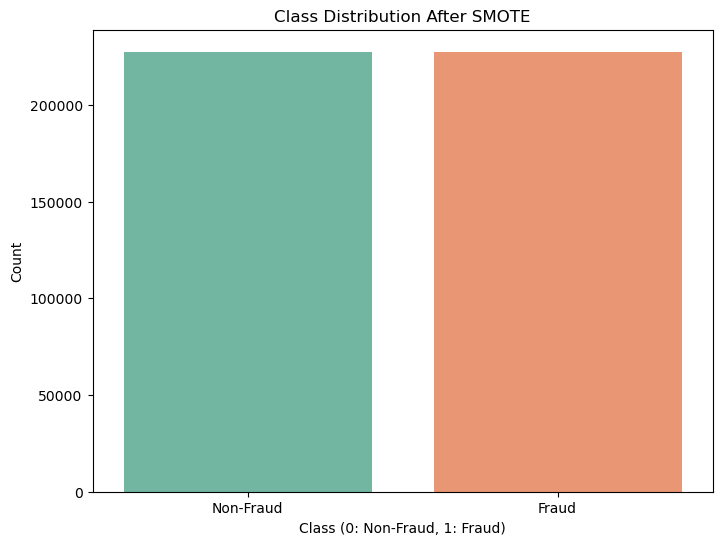

In [22]:
# Step 1: Visualize the Class Distribution After SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(data=resampled_df, x='Class', palette='Set2')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Fraud', 'Fraud'])
plt.show()

#### 3. Train a Machine Learning Model

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[56849    15]
 [   17    81]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.83      0.84        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



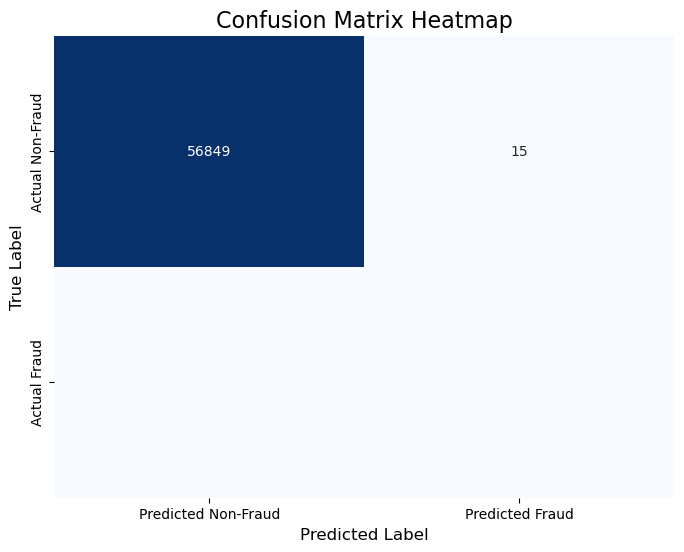

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix values
cm = [[56849, 15],  # [True Negatives, False Positives]
      [17, 81]]     # [False Negatives, True Positives]

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'],
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])

# Add labels and title
plt.title('Confusion Matrix Heatmap', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

# Show the plot
plt.show()

#### 4. Evaluate Model Performance

AUC-ROC Score: 0.98


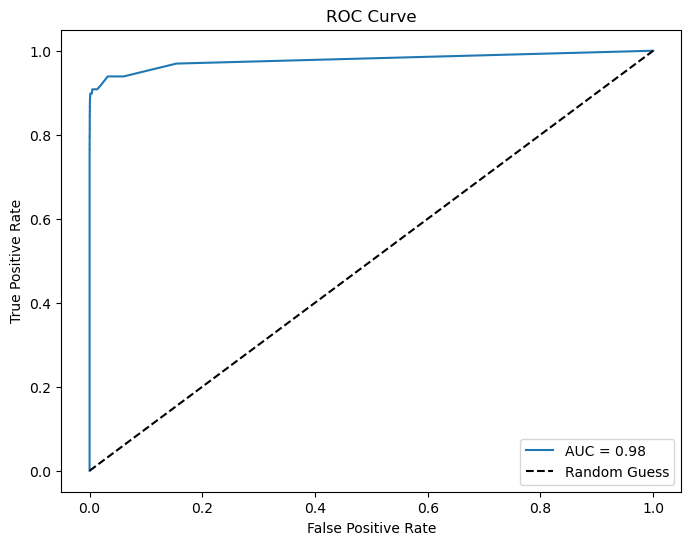

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate AUC-ROC score
auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"AUC-ROC Score: {auc_score:.2f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

#### 5. Perform Hyperparameter Tuning : Optimize the model's hyperparameters using techniques like Grid Search to improve performance.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1')
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score:", grid_search.best_score_)

# Train the final model with the best parameters
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluate the final model
print("\nClassification Report for Best Model:")
print(classification_report(y_test, y_pred_best))